In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn; patch_sklearn()

from sklearn.linear_model import (HuberRegressor, TheilSenRegressor, 
                                  LinearRegression as SkLinearRegression)
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import normalize
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps
from utils import BIC_AIC

import numpy as np; np.random.seed(0)

# from pde_diff import *
from pde_diff_new import * # moving to the newer version of PDE-FIND
from parametric_pde_find import *
from celer import GroupLasso, GroupLassoCV
# from robust_pde_diff import DLrSR, RobustPCA
# https://github.com/nerdull/denoise
# from denoise import Denoiser, kalman_denoise
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff
import pynumdiff
import sys; sys.path.insert(0, "../derivative/"); import derivative

from RobustPCA.rpca import RobustPCA
from RobustPCA.spcp import StablePCP
# from hyperspy.signals import Signal1D
from r_pca import R_pca

from scipy.integrate import odeint
from scipy.linalg import block_diag
from scipy.special import huber as hb
from scipy.signal import wiener, savgol_filter # (+0, +1)
from numpy.fft import fft, ifft, fftfreq
from best_subset import *
import statsmodels.api as sm
# from pysr import PySRRegressor

import random; SEEED = 0; random.seed(SEEED)
from random import randint, sample
from tqdm import trange, tqdm
import progressbar
from time import time
from timeit import default_timer as timer
from functools import cmp_to_key, partial

from joblib import Parallel, delayed
from multiprocess import Pool
from mpire import WorkerPool
from ray.util.multiprocessing import Pool as RayPool
from p_tqdm import p_map, p_umap
from numba import jit

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Running Python 3.7.12
You can use npar for np.array


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return deriv.real

In [3]:
# Set size of grid
n = 256
m = 256

# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

In [4]:
# just for the reference
u_clean = u.copy()
Ut_clean, Theta_clean, rhs_des_clean = build_linear_system(u_clean, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')
# np.allclose(Theta_clean[:, 1:2], u_clean.T.flatten().reshape(-1, 1)) == True
Theta_grouped_clean = [(Theta_clean[j*n:(j+1)*n,:]).real for j in range(m)]
Ut_grouped_clean = [(Ut_clean[j*n:(j+1)*n]).real for j in range(m)]
# finitediff_x = Theta_grouped[1][:, 3:4].flatten()

noise_lv = 2; noise = 0.01*np.abs(noise_lv)*u.std()*np.random.randn(n,m)
u = u + noise

if np.abs(noise_lv) > 0:
    # Build linear systems
    # D=3 and p=2 for the noise-aware physics-informed paper
    wx = 10; wt = 10
    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'poly',
                                           deg_x = 6, deg_t = 4, 
                                           width_x = wx, width_t = wt)
    n = n - 2*wx
    m = m - 2*wt
else:
    wx = 0; wt = 0
    Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')

# removing the constant term...
Theta = Theta[:, 1:]; rhs_des = rhs_des[1:]
# Group by timestep
Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]

In [5]:
n_groups = 2
steps, n_basis_candidates = Theta_grouped[0].shape

In [6]:
FTs = [sub_grouped_data((Theta_grouped, Ut_grouped), blocks) for blocks in gen_blocks(len(Theta_grouped), n_groups)]

In [7]:
# import threading
# import time

# # my function that I want to run with a timeout
# def foo(val1, val2):
#     time.sleep(5)
#     return val1+val2

# class RunWithTimeout(object):
#     def __init__(self, function, args):
#         self.function = function
#         self.args = args
#         self.answer = None

#     def worker(self):
#         self.answer = self.function(*self.args)

#     def run(self, timeout):
#         thread = threading.Thread(target=self.worker)
#         thread.start()
#         thread.join(timeout)
#         return self.answer

# # this takes about 1 second to run before yielding None
# n = RunWithTimeout(foo, (5,3))
# print(n.run(10))

In [8]:
# if max_nonzeros = 2*n_groups+1 and lam = 1e-3 -> timeout 1min time limit. 
# Try multiprocessing modules?
n_jobs = 4
partial_bnb = partial(bnb, **{'max_nonzeros':2*n_groups, 'lam':1e-3, 'corrected_coefficients':True, 'padding':False})

start_time = timer()

# joblib
# with Parallel(n_jobs=n_jobs) as pool:
#     WW = pool(delayed(partial_bnb)(F, T) for F, T in tqdm(FTs))
#     WW = [W for W in WW if W is not None]

# MPIRE
# with WorkerPool(n_jobs=n_jobs) as pool:
#     WW = pool.map(partial_bnb, (FTs), progress_bar=True, concatenate_numpy_output=False)
#     WW = [W for W in WW if W is not None]

# RAY
# with RayPool(processes=n_jobs) as pool:
#     WW = [W for W in pool.starmap(partial_bnb, tqdm(FTs, total=len(Theta_grouped))) if W is not None]

# p_tqdm | does not have to be in order? -> YES!
# p_map for order p_map
WW = p_umap(partial_bnb, 
           [FTs[i][0] for i in range(len(FTs))], 
           [FTs[i][1] for i in range(len(FTs))])

  0%|          | 0/118 [00:00<?, ?it/s]

In [9]:
# 2*n_groups+1, 1e-3 -> len(blocks) == 2 | 2*n_groups, 1e-2 -> len(blocks) == 3
# 2*n_groups, 1e-2 -> for consistency
# coeffs = bnb(F, T, 2*n_groups+1, lam=1e-3, normalize=True, corrected_coefficients=True)

# from group_lasso import GroupLasso as GL
# gl = GL(
#     groups=n_groups,
#     group_reg=5e-4,
#     l1_reg=5e-4,
#     frobenius_lipschitz=False,
#     subsampling_scheme=1,
#     supress_warning=True,
#     n_iter=50000,
#     tol=1e-5,
# )
# gl.fit(FN[:, bnb_indices], T)
# for e in set(np.nonzero(gl.coef_)[0]//n_groups): print(rhs_des[unique_bnb_indices[e]])

# clf = GroupLassoCV(alphas=[1e-1, 1e-2, 1e-3], fit_intercept=False, groups=n_groups, tol=1e-6, n_jobs=-1)
# clf.fit(FN[:, bnb_indices], T.ravel())
# for e in set(np.nonzero(clf.coef_)[0]//n_groups): print(rhs_des[unique_bnb_indices[e]])

In [10]:
alpha=1e-3
eff_indices_collection = set()
for coeffs, (F, T) in zip(WW, FTs):
    for c in range(coeffs.shape[1]):
        bnb_indices = np.nonzero(coeffs[:, c:c+1])[0]
        unique_bnb_indices = sorted(list(set(bnb_indices//n_groups)))
        bnb_indices = [f*n_groups+j for f in unique_bnb_indices for j in range(n_groups)]
        # normalize function for GroupLasso model
        FN = block_diag(*[normalize(F[i*steps:steps*(i+1), i*n_basis_candidates:n_basis_candidates*(i+1)], axis=0) for i in range(n_groups)])
        # GroupLasso
        clf = GroupLasso(alpha=alpha, fit_intercept=False, groups=n_groups, tol=1e-6)
        clf.fit(FN[:, bnb_indices], T.ravel())
        eff_indices = tuple(unique_bnb_indices[e] for e in set(np.nonzero(clf.coef_)[0]//n_groups))
        if len(eff_indices) > 0: eff_indices_collection.add(eff_indices)
eff_indices_collection

2022-10-02 17:18:44,615 [INFO] sklearn.linear_model.GroupLasso.fit: running accelerated version on CPU
2022-10-02 17:18:44,659 [INFO] sklearn.linear_model.GroupLasso.fit: running accelerated version on CPU
2022-10-02 17:18:44,662 [INFO] sklearn.linear_model.GroupLasso.fit: running accelerated version on CPU
2022-10-02 17:18:44,665 [INFO] sklearn.linear_model.GroupLasso.fit: running accelerated version on CPU
2022-10-02 17:18:44,668 [INFO] sklearn.linear_model.GroupLasso.fit: running accelerated version on CPU
2022-10-02 17:18:44,670 [INFO] sklearn.linear_model.GroupLasso.fit: running accelerated version on CPU
2022-10-02 17:18:44,673 [INFO] sklearn.linear_model.GroupLasso.fit: running accelerated version on CPU
2022-10-02 17:18:44,676 [INFO] sklearn.linear_model.GroupLasso.fit: running accelerated version on CPU
2022-10-02 17:18:44,679 [INFO] sklearn.linear_model.GroupLasso.fit: running accelerated version on CPU
2022-10-02 17:18:44,682 [INFO] sklearn.linear_model.GroupLasso.fit: runni

{(3,), (4,), (4, 7)}

In [11]:
combis = list(itertools.combinations(range(Theta_grouped[0].shape[1]), 2))
scores = []
for ci in combis:
    wei = linear_fit_grouped_data((Theta_grouped, Ut_grouped), considered_indices=ci)
    scores.append(mse_grouped_data(wei, (Theta_grouped, Ut_grouped), considered_indices=ci))

In [12]:
combis[np.argmin(scores)]

(4, 7)

In [13]:
# First, what are the best two features?
# Backward removing the least sig feature instead of looking the coef size
# GroupLasso to the subsets: (0, 1), (1, 2), (2, 3) <- defined by the size of a tuple and the overlapping size
# Implement จาก W หรือจาก l0bnb applied on the subsets ดีนะ?

In [14]:
def TrainMSGTRidge(AAs, bbs, WW, tol=1e-3, normalize=2):
    """
    Searches over values of tol to find optimal performance according to PDE_FIND_Loss.
    """

    np.random.seed(0) # for consistancy
    As, bs = AAs.copy(), bbs.copy()
    m = len(As)
    n,D = As[0].shape
    
    if normalize != 0:
        # get norm of each column
        candidate_norms = np.zeros(D)
        for i in range(D):
            candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

        # norm_bs = [Norm(b, normalize) for b in bs]
        norm_bs = [m*Norm(b, normalize) for b in bs]

        # normalize 
        for i in range(m):
            As[i] = As[i].dot(np.diag(candidate_norms**-1))
            bs[i] = bs[i]/norm_bs[i]
    
    Com = [i+1 for i in range(WW.shape[-1])]
    Losses = {}
    for com in Com:
        W = np.hstack([WW[:, :, com-1:com][i] for i in range(m)])
        xs = MSGTRidge(As, bs, W, tol=tol)
        for x in xs:
            # PDE_FIND_Loss can be modified too.
            loss = PDE_FIND_Loss(As, bs, x)
            num_sups = len(np.nonzero(np.linalg.norm(x, axis=1))[0])
            if num_sups not in Losses or loss < Losses[num_sups][0]:
                Losses[num_sups] = (loss, x)
                
    res = [np.array([num_sups, score]) for num_sups, (score, _) in sorted(Losses.items())]
    diffs = [0.0]
    for i in range(1, len(res)):
        diff = res[i]-res[i-1]
        diffs.append(diff[1]/diff[0])
    Loss, X = Losses[res[np.argmin(diffs)][0]]

    if normalize != 0:
        for i in range(D):
            for j in range(m):
                X[i,j] = X[i,j]/candidate_norms[i]*norm_bs[j]
        for i in range(m):
            As[i] = As[i].dot(np.diag(candidate_norms))
            bs[i] = bs[i]*norm_bs[i]
            
    return X, Loss

def MSGTRidge(Xs, ys, W, tol):
    """
    Sequential Threshold Group Ridge
    """
    
    # Make sure the inputs are sensible
    if len(Xs) != len(ys): raise Exception('Number of Xs and ys mismatch')
    if len(set([X.shape[1] for X in Xs])) != 1: 
        raise Exception('Number of coefficients inconsistent across timesteps')
        
    d = Xs[0].shape[1]
    m = len(Xs)
        
    num_relevant = d
    biginds = [i for i in range(d) if np.linalg.norm(W[i,:]) > tol]
    smallinds = [i for i in range(d) if i not in biginds]
    
    w_biginds = linear_fit_grouped_data((Xs, ys), considered_indices=biginds)
    W[biginds, :] = w_biginds
    W[smallinds,:] = np.zeros(m)
    Ws = [W.copy()]
    
    while len(biginds) > 1:
        ref_score = mse_grouped_data(W[biginds, :], (Xs, ys), considered_indices=biginds)
        drops = []; w_sels = []
        for i in range(len(biginds)):
            sel = tuple(biginds[:i]+biginds[i+1:])
            w_sel = linear_fit_grouped_data((Xs, ys), considered_indices=sel)
            score = mse_grouped_data(w_sel, (Xs, ys), considered_indices=sel)
            drop_score = score-ref_score
            drops.append(drop_score); w_sels.append(w_sel)
        drop_index = np.argmin(drops)
        biginds = biginds[:drop_index]+biginds[drop_index+1:]
        smallinds = [i for i in range(d) if i not in biginds]
        W[smallinds,:] = np.zeros(m)
        W[biginds, :] = w_sels[drop_index]
        Ws.append(W.copy())
        
    return Ws[::-1]

In [15]:
partial_bnb = partial(bnb, **{'max_nonzeros':3, 'lam':1e-3, 'padding':True})

# without multiprocessing
# WW = [bnb(Theta_grouped[j], Ut_grouped[j], 3, 1e-3, normalize=True, corrected_coefficients=True, padding=True) for j in progressbar.progressbar(range(len(Theta_grouped)))]
# np.save('./tmp_data/W.npy', np.array(WW))
# WW = np.load('./tmp_data/WW.npy')

### joblib ###
WW = Parallel(n_jobs=n_jobs)(delayed(partial_bnb)(Theta_grouped[i], Ut_grouped[i]) for i in trange(len(Theta_grouped)))

### multiprocess with Pool with tqdm tracking ###
# n_cores = 4
# pool = Pool(n_cores)
# WW = pool.starmap(func=partial_bnb, iterable=tqdm(zip(Theta_grouped, Ut_grouped), total=len(Theta_grouped)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [02:52<00:00,  1.36it/s]


In [16]:
xi, Losses = TrainMSGTRidge(Theta_grouped, Ut_grouped, np.array(WW), tol=1e-3)

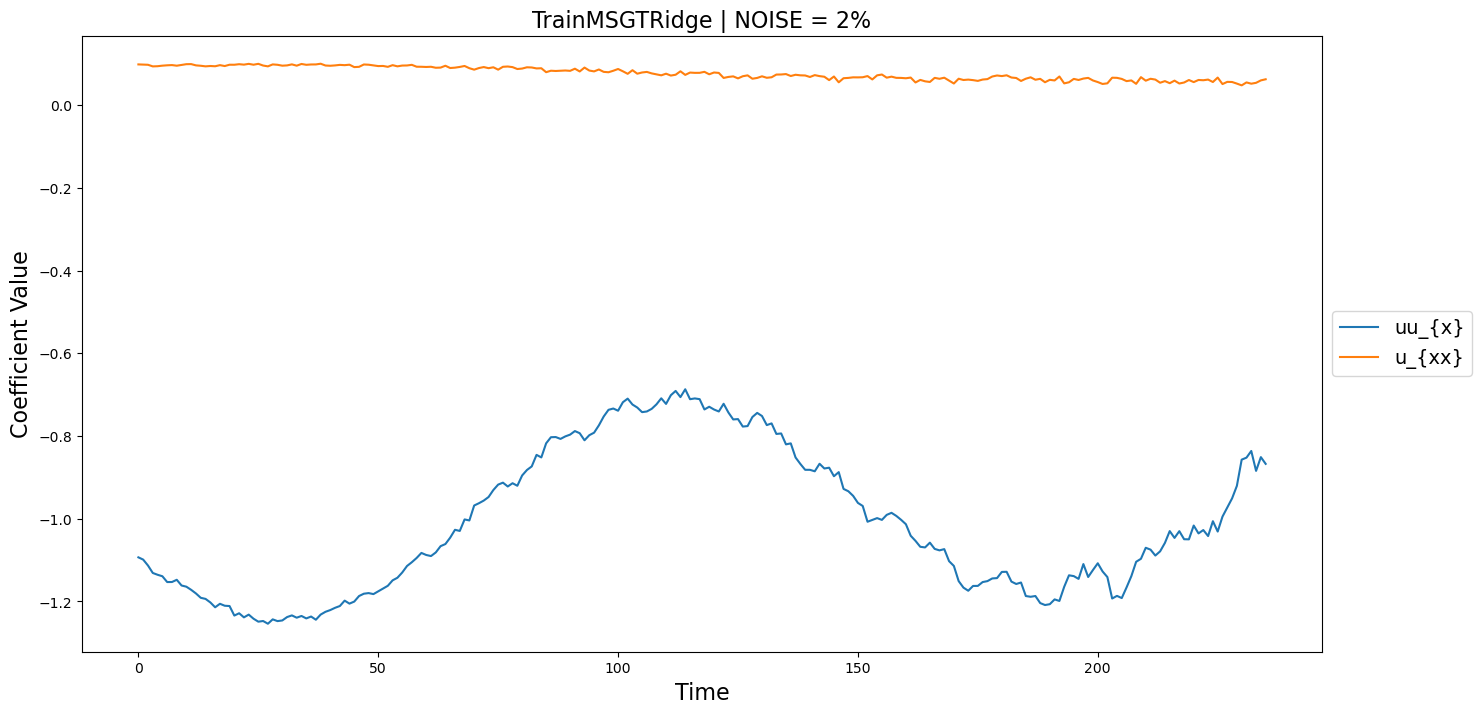

In [17]:
fig = plt.figure(figsize=(16, 8))
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plt.plot(xi[j,:], label = rhs_des[j])

plt.title(f"TrainMSGTRidge | NOISE = {int(noise_lv)}%", fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Coefficient Value', fontsize = 16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.show()